In [8]:
# Reload modules automatically
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
import math

import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='../../data', name='Cora')

data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


/nfs/homedirs/gosl/miniconda3/envs/py397/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/nfs/homedirs/gosl/miniconda3/envs/py397/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


# Average Degrees

In [63]:
def plot_degree_distr(A, max_plot_deg=None):
    deg = np.sum(A, axis=1)
    max_deg = np.max(deg)
    print(f"Average Degree: {np.sum(deg) / deg.shape[0]}")
    print(f"Maximum Degree: {max_deg}")
    c = Counter(deg)
    ordered_c = [c[i] if i in c else 0 for i in range(max_deg+1)]
    fig, axs = plt.subplots(1, 1)
    axs.plot(range(len(ordered_c)), ordered_c, 'o-')
    if max_plot_deg is not None:
        axs.set_xlim(left=0, right=max_plot_deg)

In [21]:
# Counts all edges twice!
n_intra_edges = 0
n_inter_edges = 0
n = data.num_nodes
for n1, n2 in zip(data.edge_index[0], data.edge_index[1]):
    if data.y[n1] == data.y[n2]:
        n_intra_edges += 1
    else:
        n_inter_edges += 1
print(f"Average #edges per node: {(n_intra_edges + n_inter_edges)/n}")
print(f"Average intra-connections: {n_intra_edges / n}")
print(f"Average inter-connections: {n_inter_edges / n}")

Average #edges per node: 3.8980797636632203
Average intra-connections: 3.157311669128508
Average inter-connections: 0.7407680945347119


In [22]:
# Count edges onces
A_sparse = torch.sparse_coo_tensor(data.edge_index, [1 for i in range(data.num_edges)])
A = A_sparse.to_dense()
n = data.num_nodes
n_intra_edges = 0
n_inter_edges = 0
for i in range(n):
    for j in range(i+1, n):
        if data.y[i] == data.y[j]:
            if A[i,j] == 1:
                 n_intra_edges += 1
        else:
            if A[i,j] == 1:
                 n_inter_edges += 1
print(f"Number of edges: {n_intra_edges + n_inter_edges}")
print(f"Average #edges per node: {(n_intra_edges + n_inter_edges)/n}")
print(f"Average intra-connections per node: {n_intra_edges / n}")
print(f"Average inter-connections per node: {n_inter_edges / n}")

Number of edges: 5278
Average #edges per node: 1.9490398818316101
Average intra-connections per node: 1.578655834564254
Average inter-connections per node: 0.37038404726735596


Average Degree: 3.8980797636632203
Maximum Degree: 168


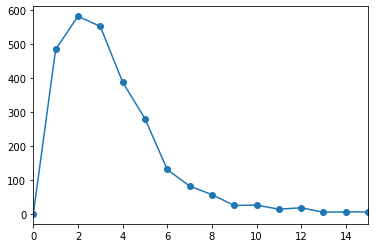

In [34]:
plot_degree_distr(A.cpu().numpy(), max_plot_deg=15)

In [2]:
print(data.edge_index.shape)

torch.Size([2, 10556])


### Contextual Barabasi-Albert model with community structure

In [8]:
from collections import Counter
import math

import matplotlib.pyplot as plt
import numpy as np
import torch

from graph_models import BAC


In [9]:
n = 1000
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
p = avg_intra_degree * 2 / (n - 1)
q = avg_inter_degree * 2 / (n - 1)
m = 2
K = 0.5 # Defines distance between means of the gaußians in sigma-units
sigma = 0.1
d = round(n / math.log(n)**2)
#d = 1
mu = np.array([K*sigma / (2 * d**0.5) for i in range(d)], dtype=np.float32)
mu = [mu, -mu]
print(mu[0].shape)
cov = sigma**2 * np.identity(d, dtype=np.float32)
pi = [0.5, 0.5]
model = BAC(p, q, m, mu, cov, pi)
X_, A_, y_ = model.sample(n, seed = 0)
print(f"Dim: {d}")

(21,)
Dim: 21


Average Degree: 3.934
Maximum Degree: 146


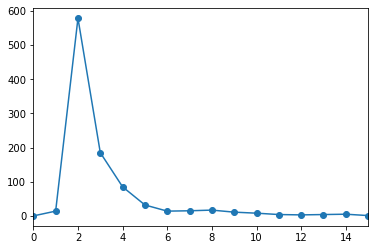

In [10]:
plot_degree_distr(A_, max_plot_deg=15)

In [37]:
n = 2708
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
p = avg_intra_degree * 2 / (n - 1)
q = avg_inter_degree * 2 / (n - 1)
m = 2
K = 0.5 # Defines distance between means of the gaußians in sigma-units
sigma = 0.1
d = round(n / math.log(n)**2)
#d = 1
mu = np.array([K*sigma / (2 * d**0.5) for i in range(d)], dtype=np.float32)
mu = [mu, -mu]
print(mu[0].shape)
cov = sigma**2 * np.identity(d, dtype=np.float32)
pi = [0.5, 0.5]
model = CBAC(p, q, m, mu, cov, pi)
X_, A_, y_ = model.sample(n, seed = 0)
print(f"Dim: {d}")

(43,)
Dim: 43


Average Degree: 3.94903988183161
Maximum Degree: 434


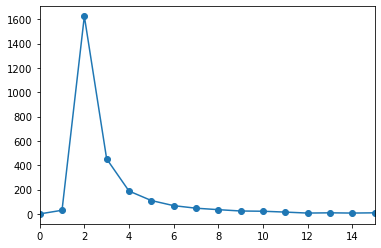

In [38]:
plot_degree_distr(A_, max_plot_deg=15)

### Contextual Barabasi-Albert model with community structure and variable degrees

In [9]:
from collections import Counter
import math

import matplotlib.pyplot as plt
import numpy as np
import torch

from graph_models import BACD

In [61]:
n = 1000
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
p = avg_intra_degree * 2 / (n - 1)
q = avg_inter_degree * 2 / (n - 1)
K = 0.5 # Defines distance between means of the gaußians in sigma-units
sigma = 0.1
d = round(n / math.log(n)**2)
#d = 1
mu = np.array([K*sigma / (2 * d**0.5) for i in range(d)], dtype=np.float32)
mu = [mu, -mu]
print(mu[0].shape)
cov = sigma**2 * np.identity(d, dtype=np.float32)
pi = [0.5, 0.5]
model = BACD(p, q, mu, cov, pi)
X_, A_, y_ = model.sample(n, seed = 0)
print(f"Dim: {d}")

(21,)
entered sample
Dim: 21


Average Degree: 4.132
Maximum Degree: 45


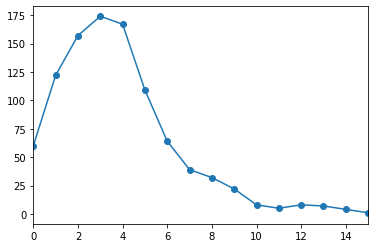

In [64]:
plot_degree_distr(A_, max_plot_deg=15)

In [65]:
n = 2708
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
p = avg_intra_degree * 2 / (n - 1)
q = avg_inter_degree * 2 / (n - 1)
K = 0.5 # Defines distance between means of the gaußians in sigma-units
sigma = 0.1
d = round(n / math.log(n)**2)
#d = 1
mu = np.array([K*sigma / (2 * d**0.5) for i in range(d)], dtype=np.float32)
mu = [mu, -mu]
print(mu[0].shape)
cov = sigma**2 * np.identity(d, dtype=np.float32)
pi = [0.5, 0.5]
model = BACD(p, q, mu, cov, pi)
X_, A_, y_ = model.sample(n, seed = 0)
print(f"Dim: {d}")

(43,)
entered sample
Dim: 43


Average Degree: 4.071639586410635
Maximum Degree: 57


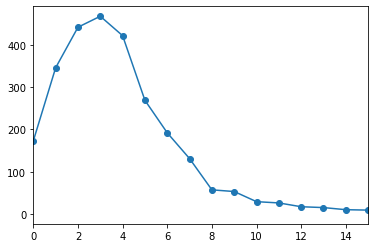

In [66]:
plot_degree_distr(A_, max_plot_deg=15)

# CSBM

In [68]:
from graph_models import CSBM

In [73]:
n = 2708
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
p = avg_intra_degree * 2 / (n - 1)
q = avg_inter_degree * 2 / (n - 1)
K = 0.5 # Defines distance between means of the gaußians in sigma-units
sigma = 0.1
d = round(n / math.log(n)**2)
#d = 1
mu = np.array([K*sigma / (2 * d**0.5) for i in range(d)], dtype=np.float32)
cov = sigma**2 * np.identity(d, dtype=np.float32)
model = CSBM(p, q, mu, cov)
X_, A_, y_ = model.sample(n, seed = 0)

Average Degree: 4.014032496307238
Maximum Degree: 13


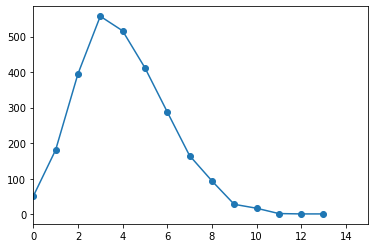

In [74]:
plot_degree_distr(A_, max_plot_deg=15)